# Usando CNN para classificar imagens de raio-x toráxico.
### As imagens estão divididas em duas classes: normais e pneumonia
#### Base de dados utilizada: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

##### Imports iniciais

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
from PIL import Image
sys.modules['Image'] = Image 

## Carregando e verificando imagens

In [47]:
train_pneumonia=os.listdir('chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('chest_xray/val/PNEUMONIA/')
test_dir_normal=os.listdir('chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('chest_xray/test/NORMAL/')

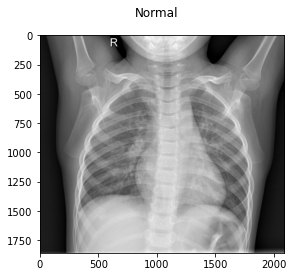

In [49]:
plt.suptitle('Normal')

img = train_normal[0]
img = load_img('chest_xray/train/NORMAL/' + img)
plt.imshow(img)
plt.show()

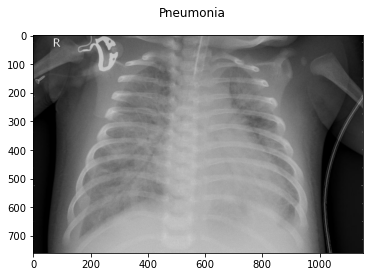

In [50]:
plt.suptitle('Pneumonia')

img = train_pneumonia[0]
img = load_img('chest_xray/train/PNEUMONIA/' + img)
plt.imshow(img)
plt.show()

## Criando sets de treino, validação e teste

In [60]:
train_datagen = ImageDataGenerator(    rescale=1/255.,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        rotation_range=0.4,
                                        zoom_range=0.4)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('chest_xray/train/',
                                                 target_size=(80, 80),
                                                 batch_size=32,
                                                 class_mode='binary')

val_set = train_datagen.flow_from_directory('chest_xray/val',
                                            target_size=(80, 80),
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode='binary')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size=(80, 80),
                                            batch_size=32,
                                            class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [61]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Setando camadas do modelo com tensorflow.keras

In [62]:
from tensorflow.keras import regularizers

model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), activation="relu",input_shape=(80, 80, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))
]
)

### Compilando o modelo e adicionando callbacks

In [63]:
model.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy', 
                      tf.keras.metrics.Precision(name = 'precision'),
                    tf.keras.metrics.Recall(name = 'recall')
                      ])

In [64]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
             EarlyStopping(patience=5)
]

In [65]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 6, 6, 256)        

### Diagrama do modelo

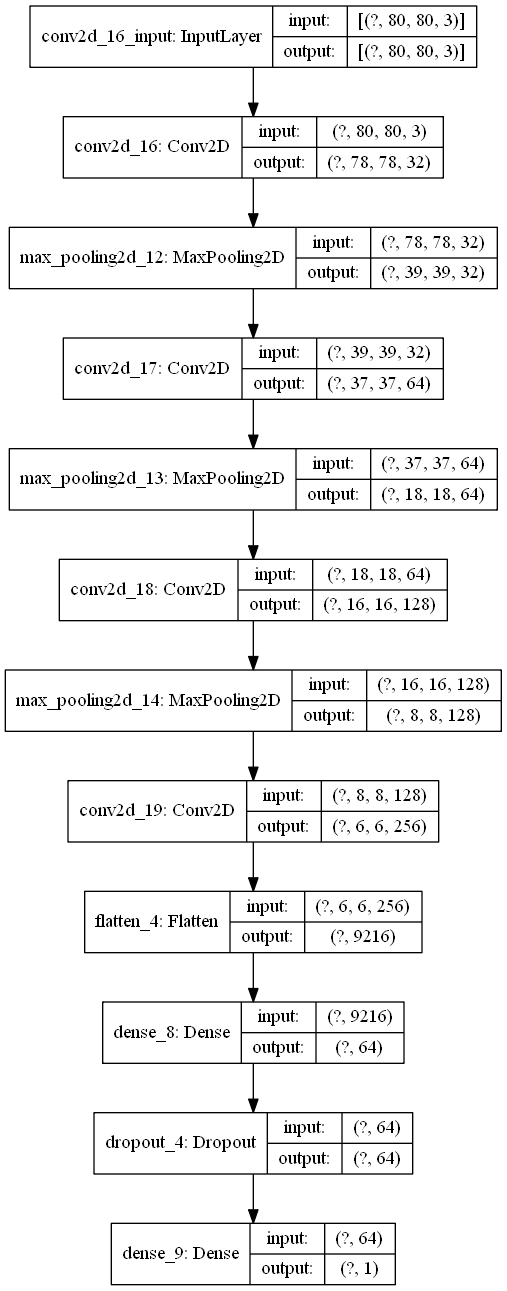

In [66]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Treinamento

In [67]:
history = model.fit(training_set, validation_data = val_set, epochs=600, callbacks= callbacks)

Epoch 1/600
163/163 [==============================] - 105s 645ms/step - loss: 0.5568 - accuracy: 0.7448 - precision: 0.7562 - recall: 0.9688 - val_loss: 1.0865 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 2/600
163/163 [==============================] - 114s 701ms/step - loss: 0.4102 - accuracy: 0.8069 - precision: 0.8336 - recall: 0.9246 - val_loss: 1.1632 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 3/600
163/163 [==============================] - 107s 659ms/step - loss: 0.3460 - accuracy: 0.8328 - precision: 0.8621 - recall: 0.9226 - val_loss: 0.9890 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/600
163/163 [==============================] - 104s 638ms/step - loss: 0.3235 - accuracy: 0.8610 - precision: 0.8934 - recall: 0.9231 - val_loss: 0.6874 - val_accuracy: 0.6250 - val_precision: 0.6000 - val_recall: 0.7500
Epoch 5/600
163/163 [==============================] - 101s 622ms/step - loss: 0.313

#### Teste

In [68]:
loss, acc, prec, rec = model.evaluate(test_set)

20/20 [==============================] - 7s 370ms/step - loss: 0.2477 - accuracy: 0.9183 - precision: 0.9291 - recall: 0.9410


### Salvando inferência do modelo
Aqui eu salvei o modelo em H5, tipo comum do keras, mas poderia usar pickle ou o saved_model do tensorflow.

In [114]:
model.save('model_inferences/model.h5')

<i>Obs: para teste rápido do modelo, executar a partir das próximas células e a primeira célula de imports</i>

In [115]:
## carregando modelo salvo
loaded_model = tf.keras.models.load_model("model_inferences/model.h5")

### Testando modelo com nova imagem

In [116]:
def predictImage(imagePath):
    test_image = load_img(imagePath, target_size=(80, 80))
    test_image = tf.keras.preprocessing.image.img_to_array(test_image, data_format=None, dtype=None)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = loaded_model.predict(test_image)
    if prediction[0][0] > 0.5:
        print("Pneumonia")
    else:
        print("Normal")

In [117]:
predictImage('google_images/pneumonia2.jpg')

Pneumonia
